In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from h5py import File
import obspy
import pandas as pd

In [2]:
coloro = "#FF6C0C"
colorb = "#00A1DF"
colorgr = "#C8C8C8"
colorp = "#F54D80"
colorg = "#1E988A"

In [3]:
%run -i "Snippets/common_functions_and_variables.py"

In [4]:
nodal_data = obspy.read("Data/PROCESSED_NODAL_SAC/*.sac")
nodal_metadata = pd.read_csv("Data/nodal_metadata.csv")

In [5]:
nodal_data.filter('bandpass', freqmin=1, freqmax=2.5, zerophase=True)

714 Trace(s) in Stream:

PG.1..EHE | 2016-03-21T07:37:21.000406Z - 2016-03-21T07:38:21.000412Z | 10.0 Hz, 601 samples
...
(712 other traces)
...
PG.99..EHZ | 2016-03-21T07:37:20.999516Z - 2016-03-21T07:38:20.999521Z | 10.0 Hz, 601 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [6]:
for tr in nodal_data:
    sta = int(tr.stats.station)
    easting = nodal_metadata[nodal_metadata["Station"]==f"N{sta:03}"]["UTM_easting_in_meters_final"].array[0]
    northing = nodal_metadata[nodal_metadata["Station"]==f"N{sta:03}"]["UTM_northing_in_meters_final"].array[0]
    orientation = float(nodal_metadata[nodal_metadata["Station"]==f"N{sta:03}"]["Orientation_from_true_North"].array[0])
    tr.stats.easting = easting
    tr.stats.northing = northing
    tr.stats.orientation = orientation

Go to Julia notebook to calculate the best fitting rectangle with a particular aspect ratio

In [7]:
corners = np.load("Data/rectangle_corners.npy")
vec1 = corners[:,0]-corners[:,1]
vec2 = corners[:,2]-corners[:,1]
l1 = np.sqrt(np.sum(np.square(vec1)))
l2 = np.sqrt(np.sum(np.square(vec2)))
t1 = np.linspace(0, l1, 33)
t2 = np.linspace(0, l2, 129)

t1 = (t1[1:]+t1[:-1])/2
t2 = (t2[1:]+t2[:-1])/2

domain_azimuth = np.rad2deg(np.arctan2(vec2[0], vec2[1]))

In [8]:
nodal_points = np.array([[tr.stats.easting, tr.stats.northing] for tr in nodal_data])
nodal_orientation = np.array([tr.stats.orientation for tr in nodal_data])

In [9]:
nodal_points_corr = nodal_points-corners[:,1]
nodal_proj_1 = l1*(nodal_points_corr@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
nodal_proj_2 = l2*(nodal_points_corr@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()

In [10]:
inbox_filter = np.logical_and(np.logical_and(nodal_proj_1>0, nodal_proj_1<l1), np.logical_and(nodal_proj_2>0, nodal_proj_2<l2))
nodal_data = obspy.Stream([tr for (i, tr) in enumerate(nodal_data) if inbox_filter[i]])
nodal_proj_1 = nodal_proj_1[inbox_filter][::3]
nodal_proj_2 = nodal_proj_2[inbox_filter][::3]
nodal_points = nodal_points[inbox_filter,:][::3,:]
nodal_orientation = nodal_orientation[inbox_filter][::3]
nodal_orientation = np.where(nodal_orientation < 180, nodal_orientation, 360-nodal_orientation)
nodal_rotation = np.deg2rad(domain_azimuth - nodal_orientation)

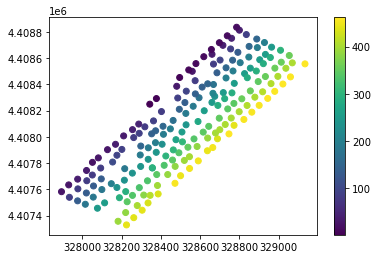

In [11]:
plt.scatter(nodal_points[:,0],nodal_points[:,1],c=nodal_proj_1)
plt.colorbar()

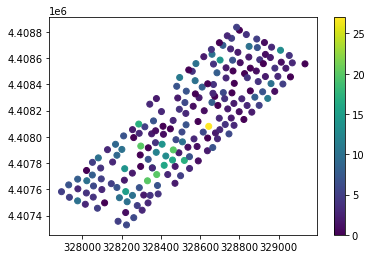

In [12]:
plt.scatter(nodal_points[:,0],nodal_points[:,1],c=nodal_orientation)
plt.colorbar()

In [13]:
nodal_data_east = np.array([tr.data for tr in nodal_data.select(channel="EHE")])
nodal_data_north = np.array([tr.data for tr in nodal_data.select(channel="EHN")])

In [14]:
axis_rotation_matrices = np.array([ np.array([[np.cos(rot), -np.sin(rot)],[np.sin(rot), np.cos(rot)]]) for rot in nodal_rotation])

In [15]:
nodal_data_rot = np.array([arm@np.array([ne, nn]) for arm, ne, nn in zip(axis_rotation_matrices, nodal_data_east, nodal_data_north)])
nodal_data_rot = np.swapaxes(nodal_data_rot, 0, 1)

In [16]:
np.save("Data/nodal_rotated_data.npy", nodal_data_rot)

In [17]:
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline as rbs
import scipy.sparse as sp

cscale = 2

generate_kernels = True

if generate_kernels:
    crv = loadmat("Data/G_32_128.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], 32, 128))
    crvscales = crv["scales"].flatten()
    cvtscaler = (2.0**(cscale*crvscales))
    G_rows = []
    G_cols = []
    G_vals = []
    for j in range(G_mat.shape[0]):
        frame = rbs(t1,t2,G_mat[j])
        G_col = frame.ev(nodal_proj_1, nodal_proj_2)
        #Currently set up so that it doesn't try to sparsify at all...(still creates a sparse matrix, but return to dense)
        G_selector = np.nonzero(np.log10(np.abs(G_col))-np.max(np.log10(np.abs(G_col))) > -15.0)[0] # if <0.1% max, get rid of it
        G_rows += [i for i in G_selector]
        G_cols += [j for i in G_selector]
        G_vals += [G_col[i]/cvtscaler[j] for i in G_selector] 
        
    
    G = sp.coo_matrix((G_vals, (G_rows, G_cols)), shape=(nodal_data_rot.shape[1], G_mat.shape[0]))
    Gn = np.sqrt(G.power(2).sum()/G.nnz - G.mean()**2)
    G = G / Gn
    Gevp = G_mat / cvtscaler[:,np.newaxis,np.newaxis] / Gn
    sp.save_npz("Data/nodal_G.npz", G)
    np.save("Data/nodal_G_evp.npy", Gevp)
    np.save("Data/nodal_G.npy", G.todense())
    sp.save_npz("Data/nodal_Gcsc.npz", G.tocsc())
    G = G.todense()
    
if not generate_kernels:
    G = np.load("Data/nodal_G.npy")
    Gevp = np.load("Data/nodal_G_evp.npy")
    Gevp = np.reshape(Gevp, (Gevp.shape[0], 128*32))
        

In [18]:
import pywt
wvt = 'db12'
nodal_wvt_data = np.swapaxes(np.array([[np.hstack(pywt.wavedec(d, wvt)) for d in data] for data in nodal_data_rot]), 1, 2)
# ncoefs, nstations = nodal_wvt_data.shape

np.save("Data/nodal_wvtdata.npy", nodal_wvt_data)


In [19]:
res1 = sp.load_npz("Results/nodal_results_1.npz")
res2 = sp.load_npz("Results/nodal_results_2.npz")

In [20]:
pred1 = np.array(G*res1)
pred2 = np.array(G*res2)

In [21]:
wvt_tmp = pywt.wavedec(nodal_data_rot[0,0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [22]:
wvt_lens

[59, 59, 95, 167, 312]

In [23]:
td_pred1 = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in pred1]))
td_pred2 = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in pred2]))

In [24]:
i = 55

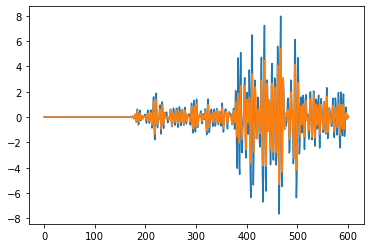

In [25]:
plt.plot(nodal_data_rot[0,i])
plt.plot(td_pred1[i])


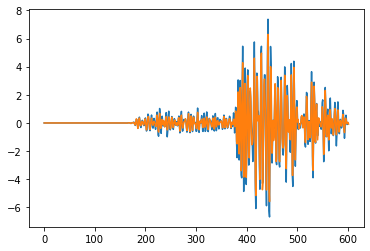

In [26]:
plt.plot(nodal_data_rot[1,i])
plt.plot(td_pred2[i])

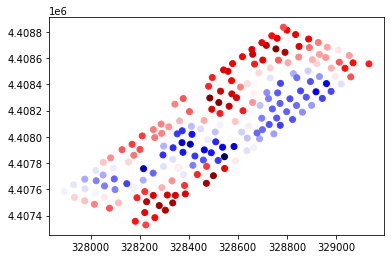

In [27]:
plt.scatter(nodal_points[:,0],nodal_points[:,1],c=nodal_data_rot[0,:,405], cmap='seismic')

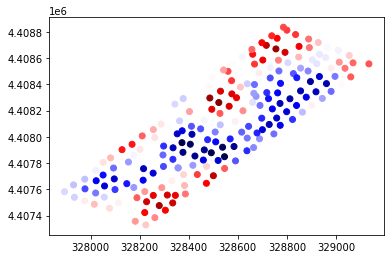

In [28]:
plt.scatter(nodal_points[:,0],nodal_points[:,1],c=td_pred1[:,405], cmap='seismic')

In [29]:
nodal_data_pred_east, nodal_data_pred_north = np.swapaxes(np.array([arm@np.array([ne, nn]) for arm, ne, nn in zip(axis_rotation_matrices, td_pred1, td_pred2)]), 0, 1)

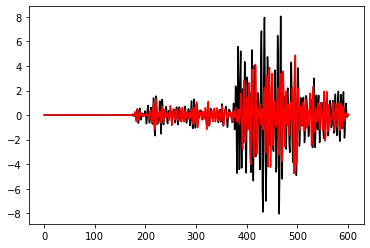

In [30]:
plt.plot(nodal_data_east[i], 'k')
plt.plot(nodal_data_pred_east[i],'r')


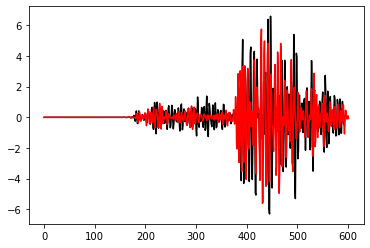

In [31]:
plt.plot(nodal_data_north[i], 'k')
plt.plot(nodal_data_pred_north[i],'r')

In [32]:
G_das = np.load("Data/G.npy")

In [33]:
das_predict = G_das @ sp.vstack([res1, res2])
das_predict_td = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in das_predict]))


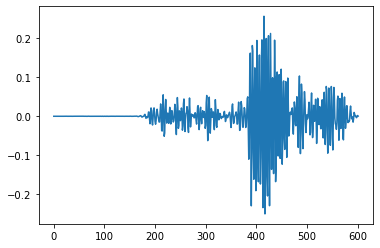

In [34]:
plt.plot(das_predict_td[2000]*0.05)

In [35]:
das_data = np.load("Data/filtdas.npy")

In [36]:
Gn_das = 5.487292209780819e-06
Gn_nodes = 0.0003260777891832482

# Gn_das = 1
# Gn_nodes = 1

In [37]:
np.sqrt(Gn_nodes/Gn_das)

7.7087074624500467

(15.0, 60.0)

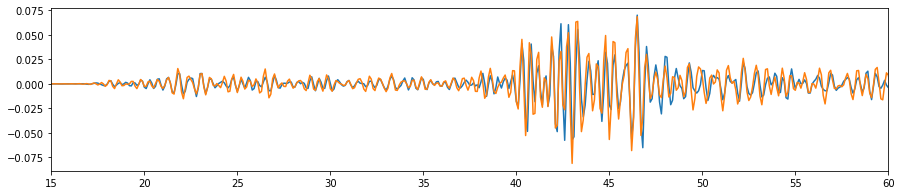

In [38]:
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(602)*0.1, das_predict_td[3000]*Gn_das/Gn_nodes)
plt.plot(np.arange(600)*0.1+1.7, das_data[3000])
plt.xlim(15,60)

In [39]:
def test_offset(i):
    return np.mean(np.square(das_predict_td[:,(150):(550)]*Gn_das/Gn_nodes - das_data[:,150-i:550-i]))

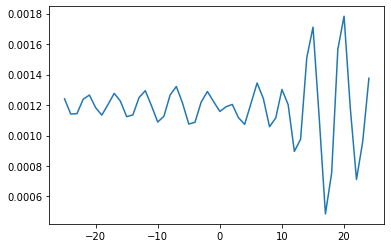

In [40]:
plt.plot(range(-25,25), [test_offset(i) for i in range(-25,25)])

In [41]:
resdas = sp.load_npz("Results/results.npz")

In [42]:
np.std(resdas.todense())

0.00080078297921947232

In [43]:
chanidx = [500,1500,2500,4900,5500,4300,6550]
channames = [ 613, 1744, 2895, 5556, 6233, 4906, 7461]

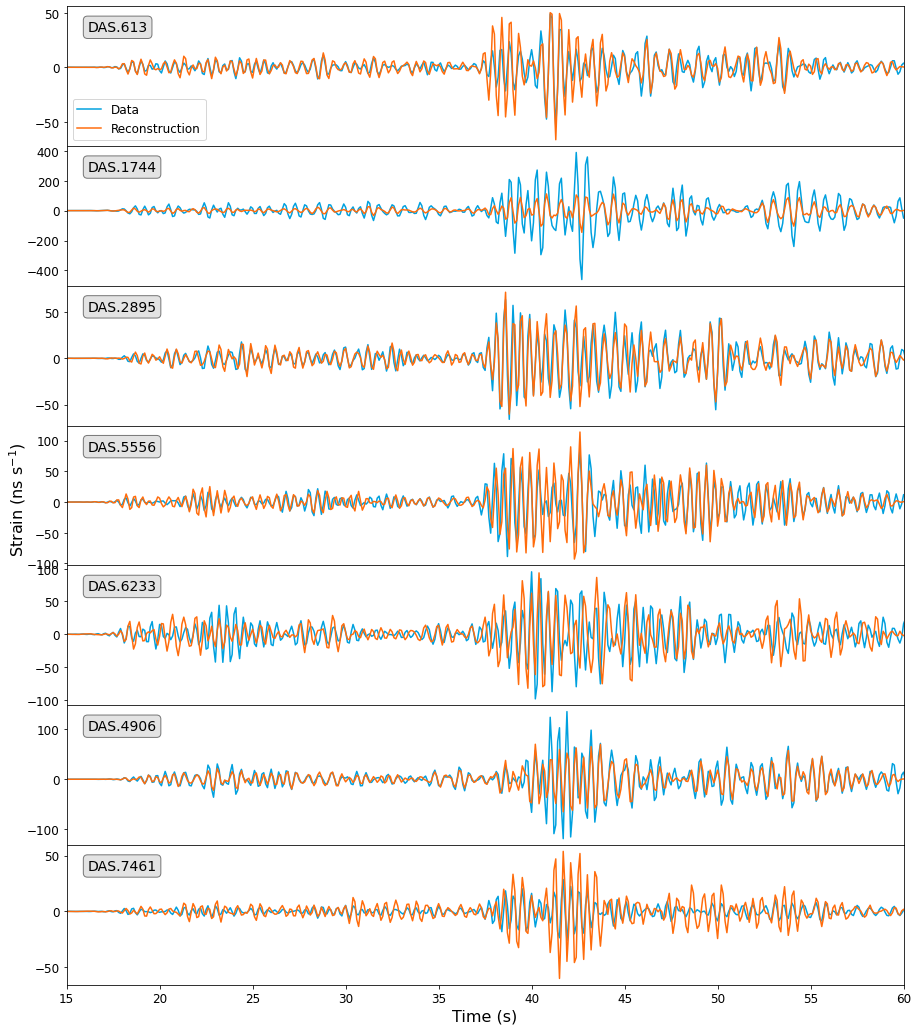

In [44]:
props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

fig, axes = plt.subplots(7,1,figsize=(15,18))

for i, (chi, chn) in enumerate(zip(chanidx, channames)):
    axes[i].plot(np.arange(600)*0.1+1.7, 1e3*das_data[chi], label="Data", color=colorb)
    axes[i].plot(np.arange(602)*0.1, 1e3*das_predict_td[chi]*Gn_das/Gn_nodes, label="Reconstruction", color=coloro)
    axes[i].text(0.025, 0.9, f"DAS.{int(chn)}", transform=axes[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    axes[i].set_xlim(15,60)
    if i != (len(axes)-1):
        axes[i].set_xticks([])
        axes[i].tick_params(axis='y', labelsize=12)
    else:
        axes[i].set_xlabel("Time (s)", fontsize=16)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

        
    if i == 0:
        axes[i].legend(loc="lower left", fontsize=12)

    
fig.subplots_adjust(hspace=0.0)
fig.text(0.07, 0.5, r'Strain (ns s$^{-1}$)', va='center', rotation='vertical', fontsize=16)
fig.savefig("node_to_das_comparison.pdf")

In [45]:
from scipy.ndimage.filters import uniform_filter1d

def running_mean_rms(trace, bin_width=10):
    return np.sqrt(uniform_filter1d(np.square(trace), size=bin_width))
    

In [46]:
agc = np.array([running_mean_rms(tr, bin_width=150) for tr in das_data])

In [47]:
das_data.shape

(7646, 600)

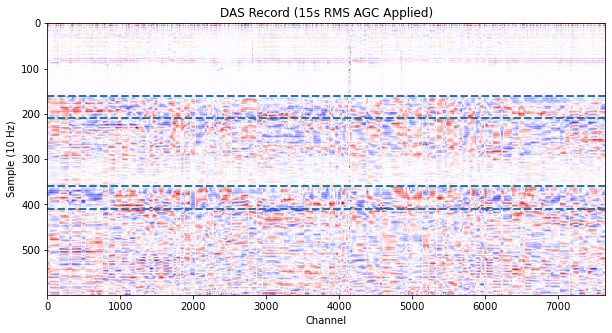

In [48]:
plt.figure(figsize=(10,5))
plt.imshow(das_data.T / agc.T, cmap='seismic', aspect='auto')
plt.axhline(160, lw=2, ls='--')
plt.axhline(210, lw=2, ls='--')

plt.axhline(360, lw=2, ls='--')
plt.axhline(410, lw=2, ls='--')
plt.title("DAS Record (15s RMS AGC Applied)")
plt.xlabel("Channel")
plt.ylabel("Sample (10 Hz)")
plt.savefig("tmpplots/a_record.pdf")

In [49]:
pstart = 160
pend = 210
sstart = 360
send = 410

p_rms = (np.sqrt(np.mean(np.square(das_data[:,pstart:pend]), axis=1))/
         np.sqrt(np.mean(np.square(das_predict_td[:,(pstart+17):(pend+17)]*Gn_das/Gn_nodes), axis=1)))

s_rms = (np.sqrt(np.mean(np.square(das_data[:,sstart:send]), axis=1))/
         np.sqrt(np.mean(np.square(das_predict_td[:,(sstart+17):(send+17)]*Gn_das/Gn_nodes), axis=1)))

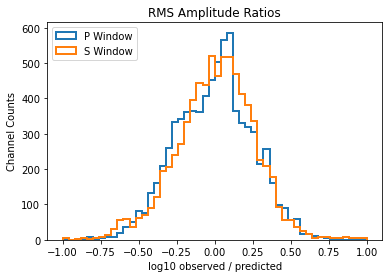

In [50]:
plt.hist(np.log10(p_rms), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(s_rms), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("RMS Amplitude Ratios")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_rmsratio.pdf")

In [51]:
e = np.load('tmp/proj_1.npy')
n = np.load('tmp/proj_2.npy')

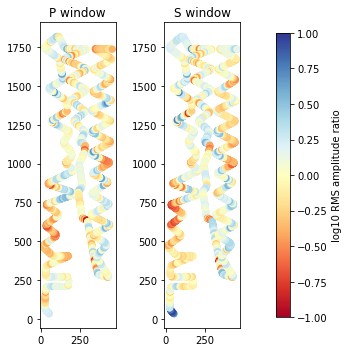

In [52]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(5,5))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cax = axes[0].scatter(e,n,c=np.log10(p_rms), cmap='RdYlBu', norm=norm)
axes[0].set_title("P window")
axes[0].set_aspect('equal')
axes[1].scatter(e,n,c=np.log10(s_rms), cmap='RdYlBu', norm=norm)
axes[1].set_title("S window")
axes[1].set_aspect('equal')

fig.colorbar(cax,fraction=0.1, use_gridspec=True, pad=0.25, label="log10 RMS amplitude ratio")
fig.tight_layout()
fig.savefig("tmpplots/a_rmsratiomaps.pdf")

In [53]:
chanidx

[500, 1500, 2500, 4900, 5500, 4300, 6550]

In [54]:
from scipy.stats import siegelslopes, linregress

1.04537041328 5.49687915436e-05 0.815132265386 5.78108815022e-13 0.107227504672
0.368976851625 3.82843542069e-05 0.837937130621 3.22532537927e-14 0.0346875921862
0.724202414975 -2.0783481516e-05 0.748967646544 3.96560116113e-10 0.0924766372479
1.13019322599 -0.000257584211474 0.680223437315 5.52020392031e-08 0.175787230436
0.446728735497 0.000205622418808 0.307491026791 0.0298386587128 0.19953674562
0.6460870537 5.48534343312e-05 0.923090562114 1.48532994655e-21 0.0388522161507
0.629996593477 -4.28538167707e-06 0.403999720957 0.00361891997158 0.205893795501


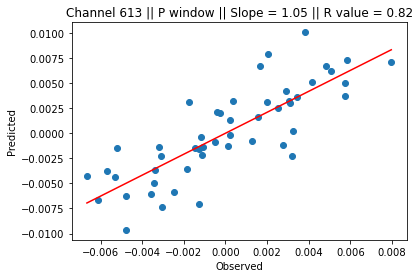

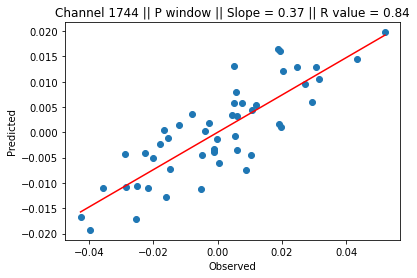

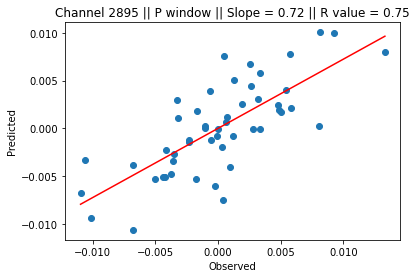

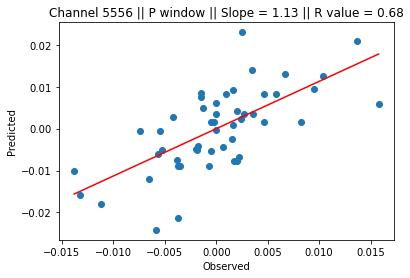

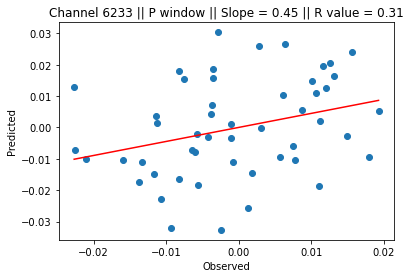

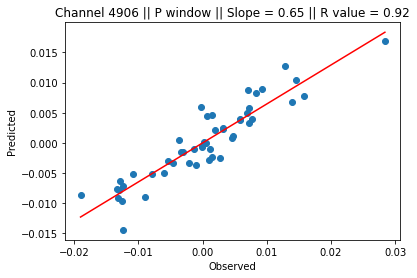

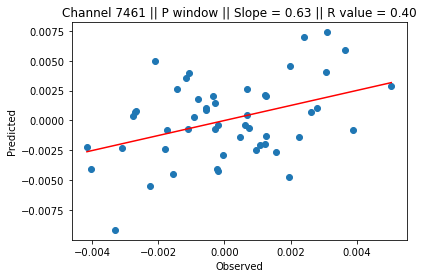

In [55]:
for cidx, cnam in zip(chanidx, channames):
    plt.figure()
    d1 = das_data[cidx,pstart:pend]
    d2 = das_predict_td[cidx,(pstart+17):(pend+17)]*Gn_das/Gn_nodes
    plt.scatter(d1,d2)

    slope, intercept, r, p, se = linregress(d1, d2)
    x = np.linspace(np.min(d1), np.max(d1), 2)
    plt.plot(x, x*slope,'r')
    plt.title(f"Channel {cnam} || P window || Slope = {slope:0.2f} || R value = {r:0.2f}")
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    print(slope, intercept, r, p, se)
    plt.savefig(f"tmpplots/a_p_lr_{cnam}.pdf")

1.20662703689 9.86187968118e-05 0.857057314489 1.98909321808e-15 0.104697470752
0.296421758201 -0.000184312421912 0.894808679579 1.96914134283e-18 0.0213467570923
0.924719635993 7.86840365093e-05 0.909228755724 6.75976571839e-20 0.0611110050583
0.881623840723 0.000621290810745 0.679342928765 5.83002860944e-08 0.137456016435
0.488114277659 -0.00150002739462 0.486154908561 0.000344459384278 0.126641009487
0.487648607122 1.81753430235e-05 0.799660888471 3.29863301975e-12 0.0528516712782
1.56396856584 0.000123463989928 0.818321544006 3.95661775723e-13 0.158551543266


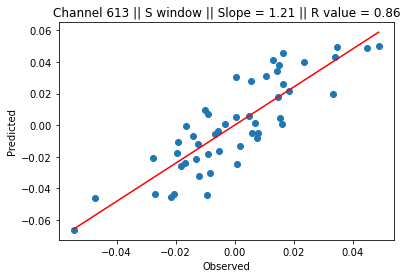

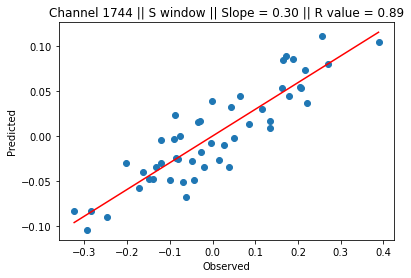

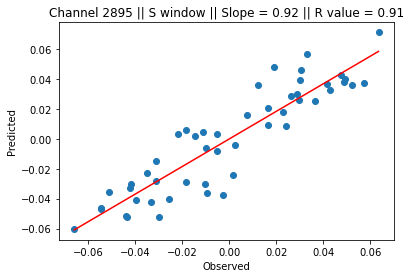

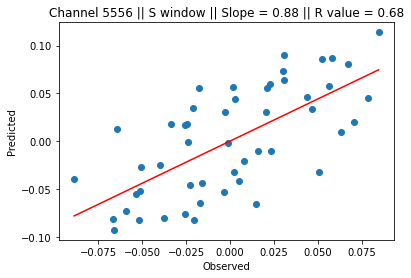

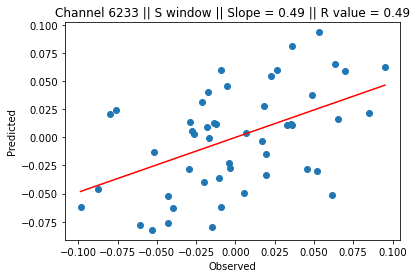

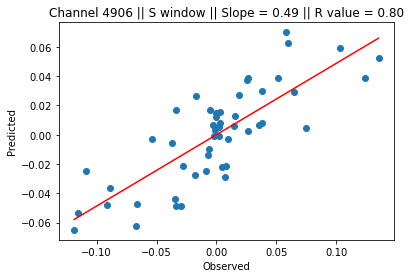

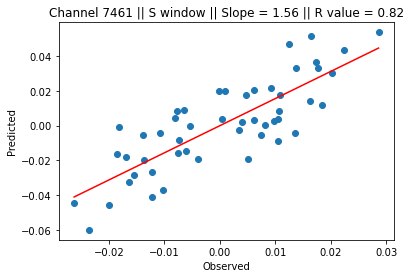

In [56]:
for cidx, cnam in zip(chanidx, channames):
    plt.figure()
    d1 = das_data[cidx,sstart:send]
    d2 = das_predict_td[cidx,(sstart+17):(send+17)]*Gn_das/Gn_nodes
    plt.scatter(d1,d2)

    slope, intercept, r, p, se = linregress(d1, d2)
    x = np.linspace(np.min(d1), np.max(d1), 2)
    plt.plot(x, x*slope,'r')
    plt.title(f"Channel {cnam} || S window || Slope = {slope:0.2f} || R value = {r:0.2f}")
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    print(slope, intercept, r, p, se)
    plt.savefig(f"tmpplots/a_s_lr_{cnam}.pdf")

In [57]:
pstart = 160
pend = 210
sstart = 360
send = 410

p_lr = np.array([linregress(d1[pstart:pend],d2[pstart+17:pend+17]*Gn_das/Gn_nodes) for d1,d2 in zip(das_data,das_predict_td)])
s_lr = np.array([linregress(d1[sstart:send],d2[sstart+17:send+17]*Gn_das/Gn_nodes) for d1,d2 in zip(das_data,das_predict_td)])

In [58]:
p_lr

array([[ -2.80777834e-01,  -3.61431979e-05,  -3.73155829e-01,
          7.60693966e-03,   1.00760817e-01],
       [ -2.63960889e-01,  -4.00774793e-05,  -3.62878229e-01,
          9.59815277e-03,   9.78357998e-02],
       [ -2.44547758e-01,  -4.24327519e-05,  -3.55523089e-01,
          1.12858892e-02,   9.27966712e-02],
       ..., 
       [  6.70372472e-01,  -2.57409865e-04,   4.02551770e-01,
          3.75324369e-03,   2.20030762e-01],
       [  7.94732928e-01,  -2.56573495e-04,   4.11527028e-01,
          2.98657883e-03,   2.54044668e-01],
       [  1.01936863e+00,  -2.58785954e-04,   4.29759542e-01,
          1.84133733e-03,   3.09133188e-01]])

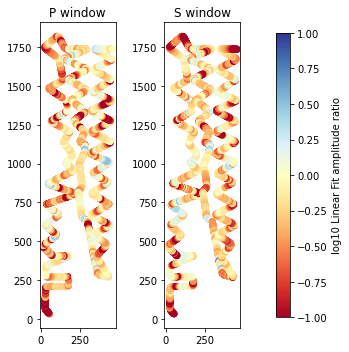

In [59]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(5,5))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cax = axes[0].scatter(e,n,c=np.log10(np.abs(p_lr[:,0])), cmap='RdYlBu', norm=norm)
axes[0].set_title("P window")
axes[0].set_aspect('equal')
axes[1].scatter(e,n,c=np.log10(np.abs(s_lr[:,0])), cmap='RdYlBu', norm=norm)
axes[1].set_title("S window")
axes[1].set_aspect('equal')

fig.colorbar(cax,fraction=0.1, use_gridspec=True, pad=0.25, label="log10 Linear Fit amplitude ratio")
fig.tight_layout()
fig.savefig("tmpplots/a_lrmap.pdf")

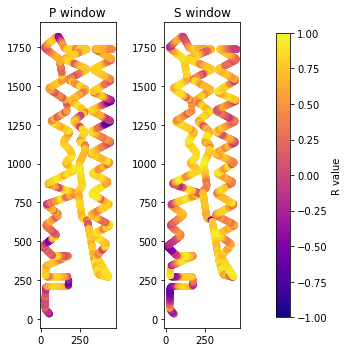

In [60]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(5,5))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cax = axes[0].scatter(e,n,c=p_lr[:,2], cmap='plasma', norm=norm)
axes[0].set_title("P window")
axes[0].set_aspect('equal')
axes[1].scatter(e,n,c=s_lr[:,2], cmap='plasma', norm=norm)
axes[1].set_title("S window")
axes[1].set_aspect('equal')

fig.colorbar(cax,fraction=0.1, use_gridspec=True, pad=0.25, label="R value")
fig.tight_layout()
fig.savefig("tmpplots/a_lrrmap.pdf")

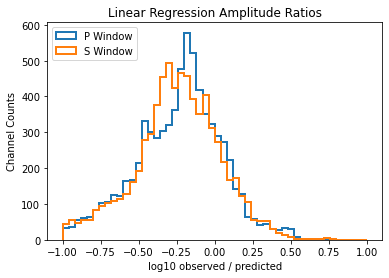

In [61]:
plt.hist(np.log10(np.abs(p_lr[:,0])), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(np.abs(s_lr[:,0])), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("Linear Regression Amplitude Ratios")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_lrratio.pdf")

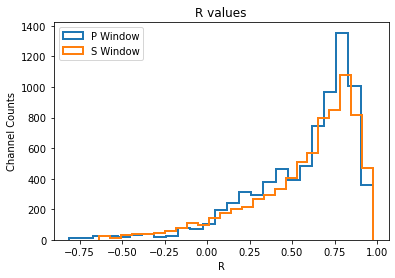

In [62]:
plt.hist(p_lr[:,2], histtype='step', lw=2, bins=25, label="P Window")
plt.hist(s_lr[:,2], histtype='step', lw=2, bins=25, label="S Window")
plt.legend(loc="upper left")
plt.title("R values")
plt.xlabel("R")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_lrr.pdf")

In [63]:
fstart = 100
fend = 500

obsData = das_data[:,fstart:fend]
preData = das_predict_td[:,(fstart+17):(fend+17)]*Gn_das/Gn_nodes
shapeData = np.zeros(obsData.shape)
Filt = np.zeros((obsData.shape[0],obsData.shape[1]//2+1), dtype=np.complex128)

In [64]:
for ich in range(obsData.shape[0]):
  # Finding filter that shapes predicted data into the observed one
  obsTrace = obsData[ich,:]
  preTrace = preData[ich,:]
  # Compute Fourier transforms
  obsTraceFFT = np.fft.rfft(obsTrace)
  preTraceFFT = np.fft.rfft(preTrace)
  # Computing auto-correlation and cross-correlation
  Acorr = preTraceFFT*np.conj(preTraceFFT)
  Xcorr = obsTraceFFT*np.conj(preTraceFFT)
  # Complex spectrum of the shaping filter
  Filt[ich,:] = Xcorr / (Acorr + np.max(np.abs(Acorr))*1e-18)
  # Convolving the filter with observed data for sanity check
  # The shapeData should exactly match the predicted data
  shapeData[ich,:] = np.fft.irfft(Filt[ich,:]*obsTraceFFT)

Text(0, 0.5, 'Phase')

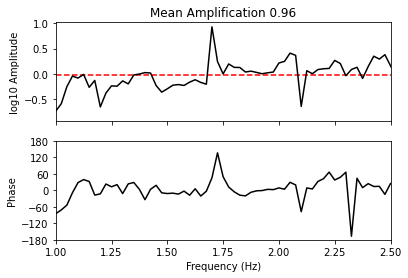

In [65]:
i = 7500
freqs = np.fft.rfftfreq(obsData.shape[1], 0.1)
fig, axes = plt.subplots(2, sharex=True)
amp = np.log10(np.abs(Filt[i,:]))
mamp = np.mean(np.log10(np.abs(Filt[i,np.logical_and(freqs>1,freqs<2.5)])))
axes[0].axhline(mamp, c='r', ls="--")
axes[0].plot(freqs, amp, c='k')
axes[0].set_xlim((1,2.5))
axes[0].set_ylabel("log10 Amplitude")
axes[0].set_title(f"Mean Amplification {10**mamp:0.2f}")
axes[1].plot(freqs, np.angle(Filt[i,:], deg=True), c='k')
axes[1].set_xlim((1,2.5))
axes[1].set_xticks([1.0,1.25,1.5,1.75,2.0,2.25,2.5])
axes[1].set_ylim((-180,180))
axes[1].set_yticks([-180,-120,-60,0,60,120,180])
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Phase")

In [66]:
mamp = np.mean(np.log10(np.abs(Filt[:,np.logical_and(freqs>1,freqs<2.5)])), axis=1)
mamp1 = np.mean(np.log10(np.abs(Filt[:,np.logical_and(freqs>1,freqs<1.5)])), axis=1)
mamp2 = np.mean(np.log10(np.abs(Filt[:,np.logical_and(freqs>1.5,freqs<2.0)])), axis=1)
mamp3 = np.mean(np.log10(np.abs(Filt[:,np.logical_and(freqs>2.0,freqs<2.5)])), axis=1)

samp = np.std(np.log10(np.abs(Filt[:,np.logical_and(freqs>1,freqs<2.5)])), axis=1)
sang = np.std(np.angle(Filt[:,np.logical_and(freqs>1,freqs<2.5)]), axis=1)

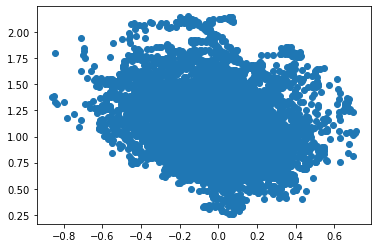

In [67]:
plt.scatter(mamp,sang)

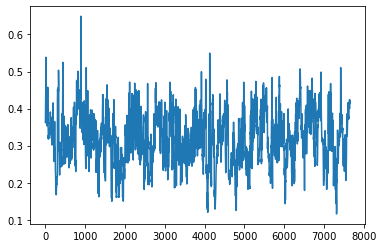

In [68]:
plt.plot(samp)

Text(0.5, 0.98, 'Mean Relative Amplification (Observed / Predicted)')

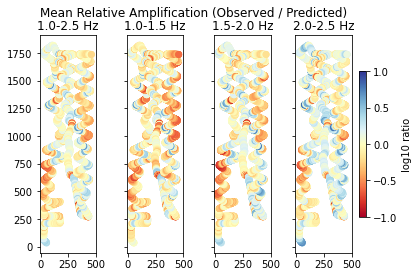

In [69]:
import matplotlib as mpl

fig, axes = plt.subplots(1,4, sharey=True)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cax = axes[0].scatter(e,n,c=mamp, cmap='RdYlBu', norm=norm)
axes[0].set_title("1.0-2.5 Hz")
axes[0].set_aspect('equal')
axes[0].set_xlabel("")
axes[0].set_xticks([0,250,500])

axes[1].scatter(e,n,c=mamp1, cmap='RdYlBu', norm=norm)
axes[1].set_title("1.0-1.5 Hz")
axes[1].set_aspect('equal')
axes[1].set_xticks([0,250,500])

cax = axes[2].scatter(e,n,c=mamp2, cmap='RdYlBu', norm=norm)
axes[2].set_title("1.5-2.0 Hz")
axes[2].set_aspect('equal')
axes[2].set_xticks([0,250,500])

cax = axes[3].scatter(e,n,c=mamp3, cmap='RdYlBu', norm=norm)
axes[3].set_title("2.0-2.5 Hz")
axes[3].set_aspect('equal')
axes[3].set_xticks([0,250,500])

fig.colorbar(cax,fraction=0.1, use_gridspec=True, pad=0.1, label="log10 ratio")
fig.suptitle("Mean Relative Amplification (Observed / Predicted)")


In [70]:
scales = 1/np.linspace(1/3.25,1/8.125,76)
freqs = pywt.scale2frequency('morl', scales)/0.1
freqs

array([ 2.5 ,  2.48,  2.46,  2.44,  2.42,  2.4 ,  2.38,  2.36,  2.34,
        2.32,  2.3 ,  2.28,  2.26,  2.24,  2.22,  2.2 ,  2.18,  2.16,
        2.14,  2.12,  2.1 ,  2.08,  2.06,  2.04,  2.02,  2.  ,  1.98,
        1.96,  1.94,  1.92,  1.9 ,  1.88,  1.86,  1.84,  1.82,  1.8 ,
        1.78,  1.76,  1.74,  1.72,  1.7 ,  1.68,  1.66,  1.64,  1.62,
        1.6 ,  1.58,  1.56,  1.54,  1.52,  1.5 ,  1.48,  1.46,  1.44,
        1.42,  1.4 ,  1.38,  1.36,  1.34,  1.32,  1.3 ,  1.28,  1.26,
        1.24,  1.22,  1.2 ,  1.18,  1.16,  1.14,  1.12,  1.1 ,  1.08,
        1.06,  1.04,  1.02,  1.  ])

In [71]:
das_predict_td.shape

(7646, 602)

In [72]:
obscwt,freqs = pywt.cwt(das_data, scales, 'morl', sampling_period=0.1)

In [73]:
precwt,freqs = pywt.cwt(das_predict_td*Gn_das/Gn_nodes, scales, 'morl', sampling_period=0.1)

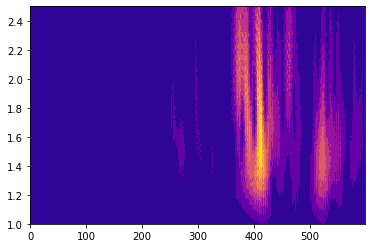

In [74]:
plt.contourf(range(600), freqs, np.abs(obscwt[:,1500,:]), cmap='plasma')

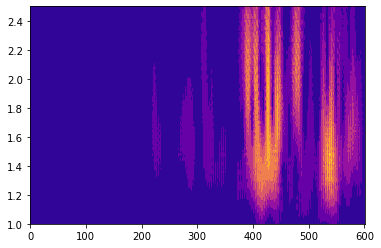

In [75]:
plt.contourf(range(602), freqs, np.abs(precwt[:,1500,:]), cmap='plasma')

In [76]:
pstart = 160
pend = 210
sstart = 360
send = 410

p_rms = (np.sqrt(np.mean(np.square(obscwt[:,:,pstart:pend]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[:,:,(pstart+17):(pend+17)]), axis=(0,2))))

s_rms = (np.sqrt(np.mean(np.square(obscwt[:,:,sstart:send]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[:,:,(sstart+17):(send+17)]), axis=(0,2))))

p_rms1 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=1,freqs<1.5),:,pstart:pend]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=1,freqs<1.5),:,(pstart+17):(pend+17)]), axis=(0,2))))

s_rms1 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=1,freqs<1.5),:,sstart:send]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=1,freqs<1.5),:,(sstart+17):(send+17)]), axis=(0,2))))

p_rms2 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=1.5,freqs<2.0),:,pstart:pend]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=1.5,freqs<2.0),:,(pstart+17):(pend+17)]), axis=(0,2))))

s_rms2 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=1.5,freqs<2.0),:,sstart:send]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=1.5,freqs<2.0),:,(sstart+17):(send+17)]), axis=(0,2))))

p_rms3 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=2.0,freqs<=2.5),:,pstart:pend]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=2.0,freqs<=2.5),:,(pstart+17):(pend+17)]), axis=(0,2))))

s_rms3 = (np.sqrt(np.mean(np.square(obscwt[np.logical_and(freqs>=2,freqs<=2.5),:,sstart:send]), axis=(0,2)))/
         np.sqrt(np.mean(np.square(precwt[np.logical_and(freqs>=2,freqs<=2.5),:,(sstart+17):(send+17)]), axis=(0,2))))

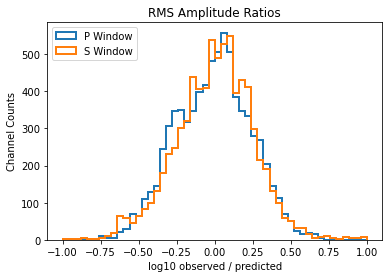

In [77]:
plt.hist(np.log10(p_rms), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(s_rms), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("RMS Amplitude Ratios")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_rmsratio.pdf")

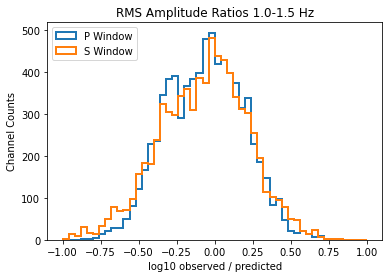

In [78]:
plt.hist(np.log10(p_rms1), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(s_rms1), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("RMS Amplitude Ratios 1.0-1.5 Hz")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_rmsratio.pdf")

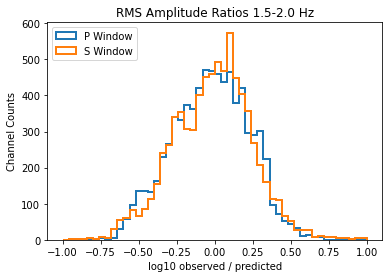

In [79]:
plt.hist(np.log10(p_rms2), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(s_rms2), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("RMS Amplitude Ratios 1.5-2.0 Hz")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_rmsratio.pdf")

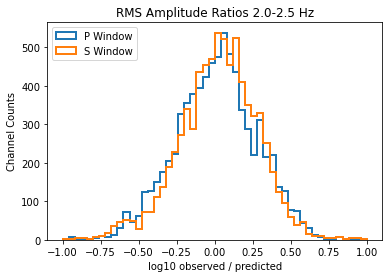

In [80]:
plt.hist(np.log10(p_rms3), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="P Window")
plt.hist(np.log10(s_rms3), histtype='step', lw=2, bins=np.linspace(-1,1,51), label="S Window")
plt.legend(loc="upper left")
plt.title("RMS Amplitude Ratios 2.0-2.5 Hz")
plt.xlabel("log10 observed / predicted")
plt.ylabel("Channel Counts")
plt.savefig("tmpplots/a_rmsratio.pdf")

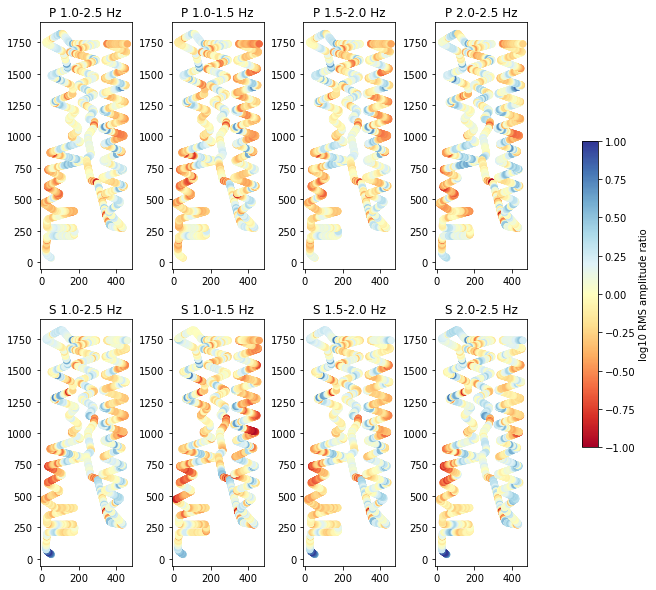

In [81]:
import matplotlib as mpl

fig = plt.figure(constrained_layout=False, figsize=(10,10))
widths = [3, 3, 3, 3, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=5, nrows=2, width_ratios=widths,
                          height_ratios=heights, wspace=0.5)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

ax = fig.add_subplot(spec[0,0])
cax = ax.scatter(e,n,c=np.log10(p_rms), cmap='RdYlBu', norm=norm)
ax.set_title("P 1.0-2.5 Hz")

ax = fig.add_subplot(spec[0,1])
ax.scatter(e,n,c=np.log10(p_rms1), cmap='RdYlBu', norm=norm)
ax.set_title("P 1.0-1.5 Hz")



ax = fig.add_subplot(spec[0,2])
ax.scatter(e,n,c=np.log10(p_rms2), cmap='RdYlBu', norm=norm)
ax.set_title("P 1.5-2.0 Hz")


ax = fig.add_subplot(spec[0,3])
ax.scatter(e,n,c=np.log10(p_rms3), cmap='RdYlBu', norm=norm)
ax.set_title("P 2.0-2.5 Hz")



ax = fig.add_subplot(spec[1,0])
ax.scatter(e,n,c=np.log10(s_rms), cmap='RdYlBu', norm=norm)
ax.set_title("S 1.0-2.5 Hz")

ax = fig.add_subplot(spec[1,1])
ax.scatter(e,n,c=np.log10(s_rms1), cmap='RdYlBu', norm=norm)
ax.set_title("S 1.0-1.5 Hz")

ax = fig.add_subplot(spec[1,2])
ax.scatter(e,n,c=np.log10(s_rms2), cmap='RdYlBu', norm=norm)
ax.set_title("S 1.5-2.0 Hz")

ax = fig.add_subplot(spec[1,3])
ax.scatter(e,n,c=np.log10(s_rms3), cmap='RdYlBu', norm=norm)
ax.set_title("S 2.0-2.5 Hz")

ax = fig.add_subplot(spec[:,4])
ax.axis('off')
fig.colorbar(cax,fraction=0.5, ax=ax, label="log10 RMS amplitude ratio")
fig.savefig("ampratio_cwt.pdf")

In [82]:
mrms = np.median(np.array([p_rms1, p_rms2, p_rms3, s_rms1, s_rms2, s_rms3]), axis=0)

In [83]:
bradymodel = pd.read_csv("Data/MESHEDTOMO_20190108.csv")

In [84]:
bradylitho = bradymodel["ID15_SilerLithology"]
bradyvp = bradymodel["ID14_Vp_Nayak20180513"]
bradyvp = bradymodel["ID13_Vp_Thurber20180504"]
bradyx = bradymodel["Xp"]
bradyy = bradymodel["Yp"]
bradyz = bradymodel["Zp"]

In [85]:
bradylitho = np.reshape(bradylitho.array, (20,22,62))
bradyvp = np.reshape(bradyvp.array, (20,22,62))
bradyx = np.reshape(bradyx.array, (20,22,62))
bradyy = np.reshape(bradyy.array, (20,22,62))
bradyz = np.reshape(bradyz.array, (20,22,62))

In [86]:
bradyz[-3,:,:]+800

array([[ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5],
       [ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5],
       [ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5],
       ..., 
       [ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5],
       [ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5],
       [ 1212.5,  1212.5,  1212.5, ...,  1212.5,  1212.5,  1212.5]])

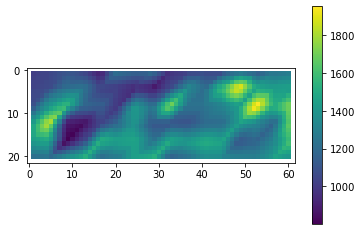

In [87]:
plt.imshow(bradyvp[-3,:,:])
plt.colorbar()

In [88]:
bradyz

array([[[ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5],
        [ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5],
        [ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5],
        ..., 
        [ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5],
        [ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5],
        [ -12.5,  -12.5,  -12.5, ...,  -12.5,  -12.5,  -12.5]],

       [[  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
        [  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
        [  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
        ..., 
        [  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
        [  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
        [  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5]],

       [[  37.5,   37.5,   37.5, ...,   37.5,   37.5,   37.5],
        [  37.5,   37.5,   37.5, ...,   37.5,   37.5,   37.5],
        [  37.5,   37.5,   37.5, ...,   37.5,   37.5,   37.5],
        ..., 
        [

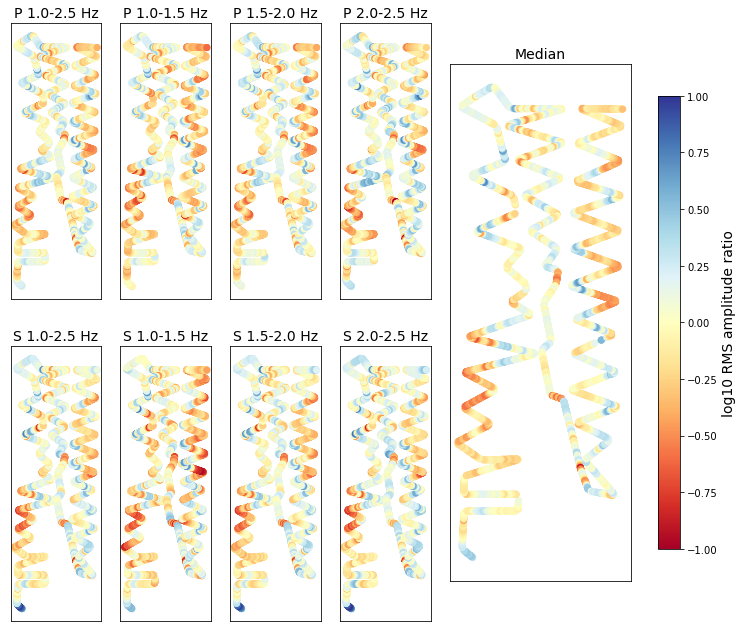

In [89]:
import matplotlib as mpl

fig = plt.figure(constrained_layout=False, figsize=(12,11))
widths = [3, 3, 3, 3, 6, 1]
heights = [1 for i in range(15)]
spec = fig.add_gridspec(ncols=6, nrows=15, width_ratios=widths,
                          height_ratios=heights, wspace=0.2, hspace=0.2)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

ax = fig.add_subplot(spec[0:7,0])
cax = ax.scatter(e,n,c=np.log10(p_rms), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_ylabel("Northing (m)", fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("P 1.0-2.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[0:7,1])
ax.scatter(e,n,c=np.log10(p_rms1), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("P 1.0-1.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[0:7,2])
ax.scatter(e,n,c=np.log10(p_rms2), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("P 1.5-2.0 Hz", fontsize=14)

ax = fig.add_subplot(spec[0:7,3])
ax.scatter(e,n,c=np.log10(p_rms3), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("P 2.0-2.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[8:,0])
ax.scatter(e,n,c=np.log10(s_rms), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Easting (m)", fontsize=12)
# ax.set_ylabel("Northing (m)", fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("S 1.0-2.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[8:,1])
ax.scatter(e,n,c=np.log10(s_rms1), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Easting (m)", fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_yticks([])
ax.set_title("S 1.0-1.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[8:,2])
ax.scatter(e,n,c=np.log10(s_rms2), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Easting (m)", fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_yticks([])
ax.set_title("S 1.5-2.0 Hz", fontsize=14)

ax = fig.add_subplot(spec[8:,3])
ax.scatter(e,n,c=np.log10(s_rms3), cmap='RdYlBu', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Easting (m)", fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_yticks([])
ax.set_title("S 2.0-2.5 Hz", fontsize=14)

ax = fig.add_subplot(spec[1:14,4])
ax.scatter(e,n,c=np.log10(mrms), cmap="RdYlBu", norm=norm)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("Easting (m)", fontsize=12)
# ax.set_ylabel("Northing (m)", fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("Median", fontsize=14)

ax = fig.add_subplot(spec[:,5])
ax.axis('off')
cb = fig.colorbar(cax, fraction=0.75, ax=ax)
cb.set_label(label='log10 RMS amplitude ratio', size=14)
fig.savefig("ampratio_cwt.pdf")

In [90]:
Gxx = np.load("Data/Gxx.npy")
Gxy = np.load("Data/Gxy.npy")
Gyx = np.load("Data/Gyx.npy")
Gyy = np.load("Data/Gyy.npy")

In [91]:
exx_wvt = Gxx@res1
exy_wvt = Gxy@res1 + Gyx@res2
eyy_wvt = Gyy@res2

exx_td = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in exx_wvt]))[:,(150+17):(550+17)]*Gn_das/Gn_nodes
exy_td = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in exy_wvt]))[:,(150+17):(550+17)]*Gn_das/Gn_nodes
eyy_td = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in eyy_wvt]))[:,(150+17):(550+17)]*Gn_das/Gn_nodes

In [92]:
das_data_obs = das_data[:,150:550]
das_data_pred = das_predict_td[:,(150+17):(550+17)]*Gn_das/Gn_nodes

In [93]:
def solve_J(d_obs, d_pred, exx, exy, eyy):
    delta = d_obs - d_pred
    e = np.hstack([exx[:,np.newaxis], exy[:,np.newaxis], eyy[:,np.newaxis]])
    J = np.linalg.solve(e.T @ e, e.T @ delta)
    return J

def correct_das(J, d_pred, exx, exy, eyy):
    e = np.hstack([exx[:,np.newaxis], exy[:,np.newaxis], eyy[:,np.newaxis]])
    return d_pred + e@J

In [94]:
Js = np.array([solve_J(d_obs,d_pred,exx,exy,eyy) for d_obs,d_pred,exx,exy,eyy in zip(das_data_obs, das_data_pred, exx_td, exy_td, eyy_td)])

In [95]:
dJs = np.array([j[0]*j[2]-(j[1]**2)/4 for j in Js])

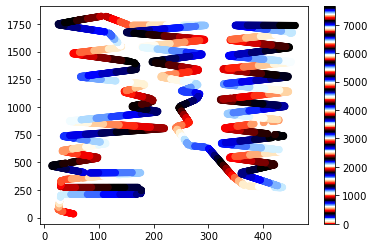

In [96]:
plt.scatter(e,n, c=range(len(e)), cmap='flag')
plt.colorbar()

In [97]:
np.argmin(s_rms[:2000])

1214

(15.0, 60.0)

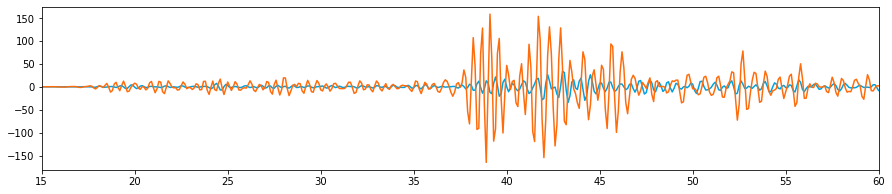

In [98]:
chi = 1214
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(600)*0.1+1.7, 1e3*das_data[chi], label="Data", color=colorb)
plt.plot(np.arange(602)*0.1, 1e3*das_predict_td[chi]*Gn_das/Gn_nodes, label="Reconstruction", color=coloro)
plt.xlim(15,60)

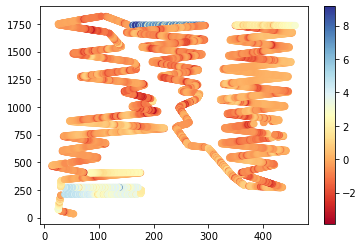

In [99]:
plt.scatter(e,n, c=np.log10(np.abs(dJs)), cmap='RdYlBu')
plt.colorbar()

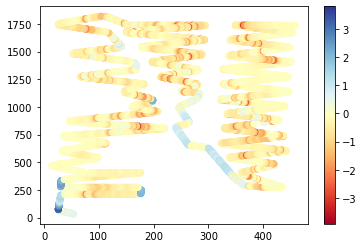

In [100]:
plt.scatter(e,n,c=np.log10(np.abs(Js[:,0])), cmap="RdYlBu")
plt.colorbar()

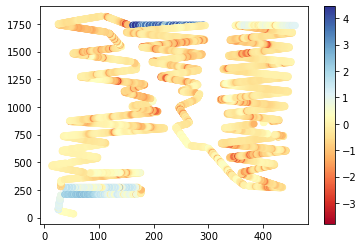

In [101]:
plt.scatter(e,n,c=np.log10(np.abs(Js[:,1])), cmap="RdYlBu")
plt.colorbar()

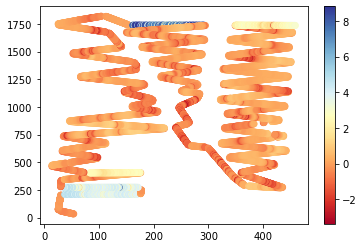

In [102]:
plt.scatter(e,n,c=np.log10(np.abs(Js[:,2])), cmap="RdYlBu")
plt.colorbar()

In [103]:
das_pred_corr = np.array([correct_das(J,d_pred,exx,exy,eyy) for J,d_pred,exx,exy,eyy in zip(Js, das_data_pred, exx_td, exy_td, eyy_td)])

In [104]:
from obspy.signal.cross_correlation import correlate_template

In [105]:
from scipy.signal import hilbert

In [106]:
das_data_obs_amp = np.log(np.array([np.abs(hilbert(t)) for t in das_data_obs]))
das_data_pred_amp = np.log(np.array([np.abs(hilbert(t)) for t in das_data_pred]))
das_data_naive_pred_amp = np.log(np.array([np.abs(hilbert(m*t)) for (m,t) in zip(mrms, das_data_pred)]))
das_pred_corr_amp = np.log(np.array([np.abs(hilbert(t)) for t in das_pred_corr]))
das_data_obs_amp_iqr = np.quantile(das_data_obs_amp, 0.75, axis=1)-np.quantile(das_data_obs_amp, 0.25, axis=1)
das_data_pred_amp_iqr = np.quantile(das_data_pred_amp, 0.75, axis=1)-np.quantile(das_data_pred_amp, 0.25, axis=1)
das_pred_corr_amp_iqr = np.quantile(das_pred_corr_amp, 0.75, axis=1)-np.quantile(das_pred_corr_amp, 0.25, axis=1)

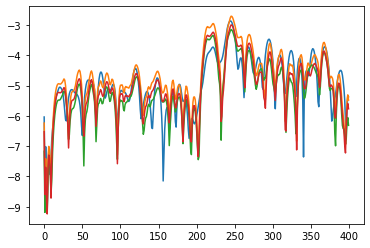

In [107]:
plt.plot(das_data_obs_amp[500])
plt.plot(das_data_pred_amp[500])
plt.plot(das_pred_corr_amp[500])
plt.plot(das_data_naive_pred_amp[500])

In [108]:
rms1 = np.sqrt(np.mean(np.square(das_data_obs_amp-das_data_pred_amp), axis=1))/das_data_obs_amp_iqr
rms2 = np.sqrt(np.mean(np.square(das_data_obs_amp-das_pred_corr_amp), axis=1))/das_data_obs_amp_iqr
rms3 = np.sqrt(np.mean(np.square(das_data_obs_amp-das_data_naive_pred_amp), axis=1))/das_data_obs_amp_iqr
cc1 = np.array([correlate_template(d1,d2) for d1,d2 in zip(das_data_obs, das_data_pred)])
cc2 = np.array([correlate_template(d1,d2) for d1,d2 in zip(das_data_obs, das_pred_corr)])

In [109]:
np.median(np.exp(rms1))

1.8314961492941411

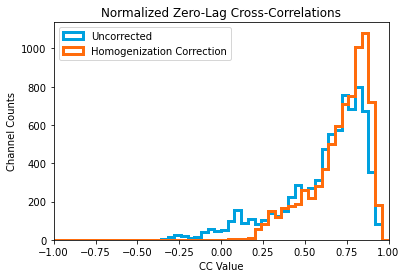

In [110]:
plt.hist(cc1, histtype='step', lw=3, bins=np.linspace(-1,1,51), label="Uncorrected", color=colorb)
plt.hist(cc2, histtype='step', lw=3, bins=np.linspace(-1,1,51), label="Homogenization Correction", color=coloro)

plt.xlim(-1,1)
plt.legend(loc="upper left")
plt.title("Normalized Zero-Lag Cross-Correlations")
plt.xlabel("CC Value")
plt.ylabel("Channel Counts")
plt.savefig("cc_hist.pdf")

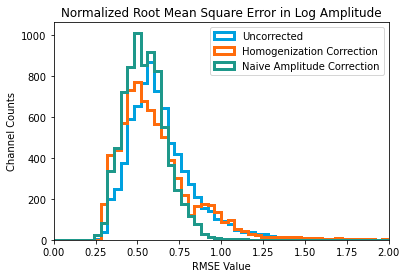

In [111]:
plt.hist(rms1, histtype='step', lw=3, bins=np.linspace(0,2,51), label="Uncorrected", color=colorb)
plt.hist(rms2, histtype='step', lw=3, bins=np.linspace(0,2,51), label="Homogenization Correction", color=coloro)
plt.hist(rms3, histtype='step', lw=3, bins=np.linspace(0,2,51), label="Naive Amplitude Correction", color=colorg)

plt.xlim(0,2)
plt.legend(loc="upper right")
plt.title("Normalized Root Mean Square Error in Log Amplitude")
plt.xlabel("RMSE Value")
plt.ylabel("Channel Counts")
plt.savefig("rmse_hist.pdf")

(15.0, 60.0)

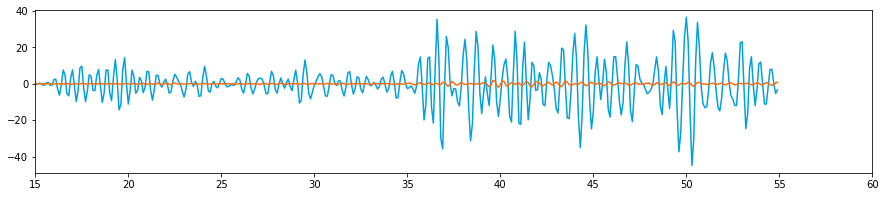

In [129]:
chi = np.argmax(rms2)
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(15+np.arange(400)*0.1, 1e3*das_data_obs[chi], label="Data", color=colorb)
plt.plot(15+np.arange(400)*0.1, 1e3*das_pred_corr[chi], label="Corrected Reconstruction", color=coloro)
plt.xlim(15,60)

Text(0, 0.5, 'Homogenization RMS')

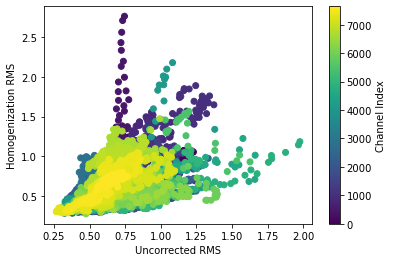

In [135]:
plt.scatter(rms1,rms2, c=np.arange(len(rms1)))
plt.colorbar(label="Channel Index")
plt.xlabel("Uncorrected RMS")
plt.ylabel("Homogenization RMS")

Text(0, 0.5, 'Homogenization RMS')

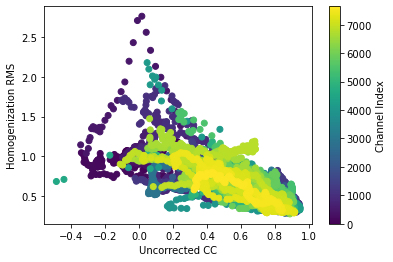

In [138]:
plt.scatter(cc1,rms2, c=np.arange(len(rms1)))
plt.colorbar(label="Channel Index")
plt.xlabel("Uncorrected CC")
plt.ylabel("Homogenization RMS")

Text(0, 0.5, 'Homogenization CC')

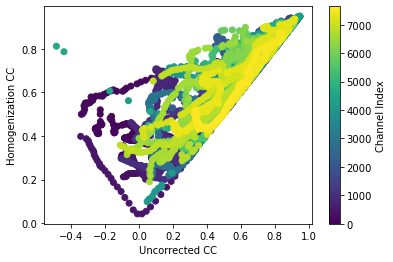

In [149]:
plt.scatter(cc1,cc2, c=np.arange(len(rms1)))
plt.colorbar(label="Channel Index")
plt.xlabel("Uncorrected CC")
plt.ylabel("Homogenization CC")

Text(0.5, 1.0, 'Yellow:0.8<=Corrected RMS<=1.2')

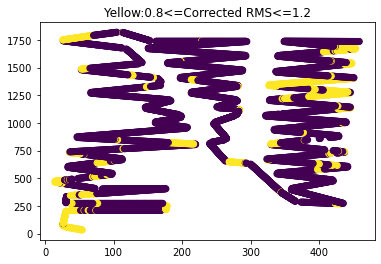

In [146]:
plt.scatter(e,n,c=np.logical_and(rms2>=0.8,rms2<=1.2))
plt.title("Yellow:0.8<=Corrected RMS<=1.2")

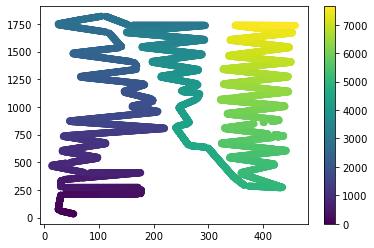

In [139]:
plt.scatter(e,n,c=np.arange(len(rms2)))
plt.colorbar()

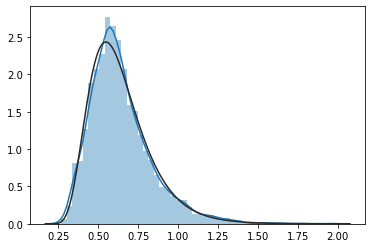

In [112]:
import seaborn as sns
import numpy as np
from scipy import stats

sns.distplot(rms1, fit=stats.lognorm) # log normal distribution
# sns.distplot(rms2, fit=stats.lognorm) # log normal distribution
# sns.distplot(rms3, fit=stats.lognorm)

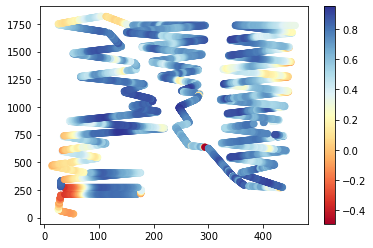

In [113]:
plt.scatter(e,n,c=cc1, cmap="RdYlBu")
plt.colorbar()

In [114]:
np.mean(rms1), np.mean(rms2)

(0.64016327632767245, 0.61414514026055733)

In [115]:
np.median(rms1), np.median(rms2), np.median(rms3)

(0.6051332007073873, 0.56248122979604775, 0.53527042303013761)

In [116]:
np.mean(cc1), np.mean(cc2)

(0.61224982936957417, 0.70932838813617927)

In [117]:
np.median(cc1), np.median(cc2)

(0.68762406673418341, 0.75568861244541941)

In [118]:
cc1[chi][0]

-0.023920551943045043

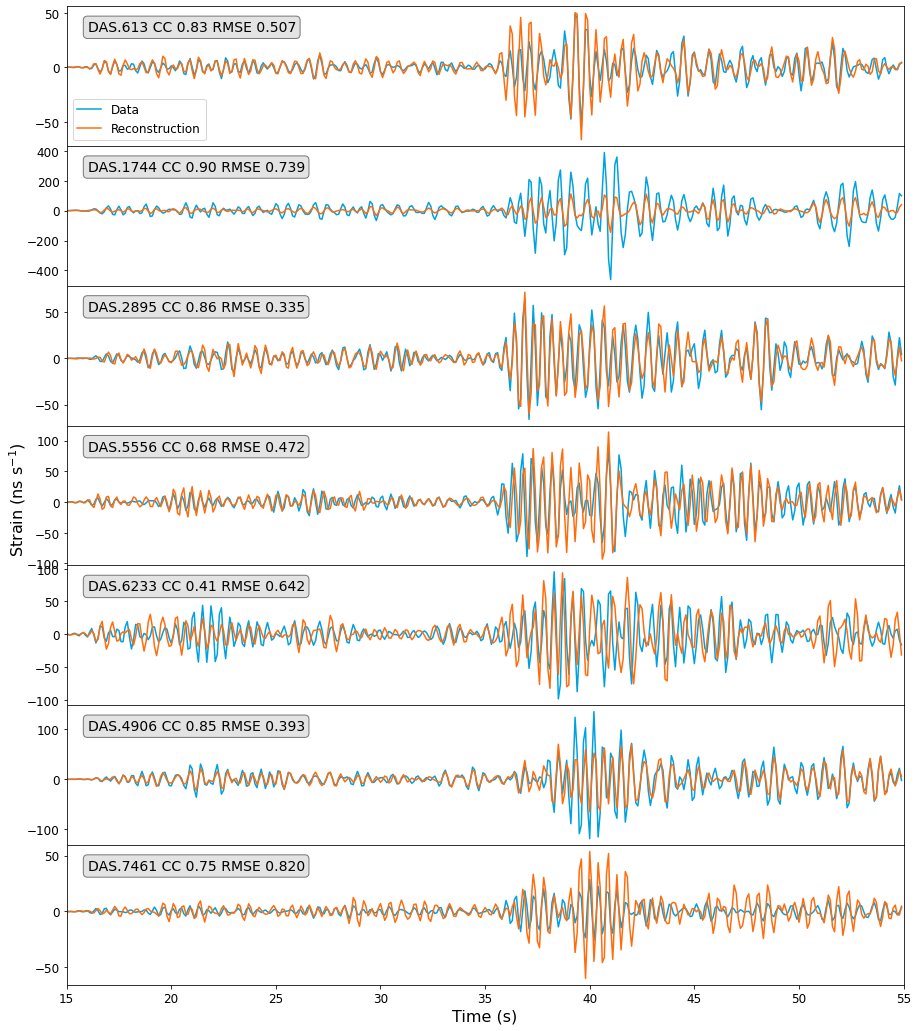

In [119]:
props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

fig, axes = plt.subplots(7,1,figsize=(15,18))

for i, (chi, chn) in enumerate(zip(chanidx, channames)):
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_data_obs[chi], label="Data", color=colorb)
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_data_pred[chi], label="Reconstruction", color=coloro)

    axes[i].text(0.025, 0.9, f"DAS.{int(chn)} CC {cc1[chi][0]:.2f} RMSE {rms1[chi]:.3f}", transform=axes[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    axes[i].set_xlim(15,55)
    if i != (len(axes)-1):
        axes[i].set_xticks([])
        axes[i].tick_params(axis='y', labelsize=12)
    else:
        axes[i].set_xlabel("Time (s)", fontsize=16)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

        
    if i == 0:
        axes[i].legend(loc="lower left", fontsize=12)

    
fig.subplots_adjust(hspace=0.0)
fig.text(0.07, 0.5, r'Strain (ns s$^{-1}$)', va='center', rotation='vertical', fontsize=16)
fig.savefig("node_to_das_comparison_stats.pdf")

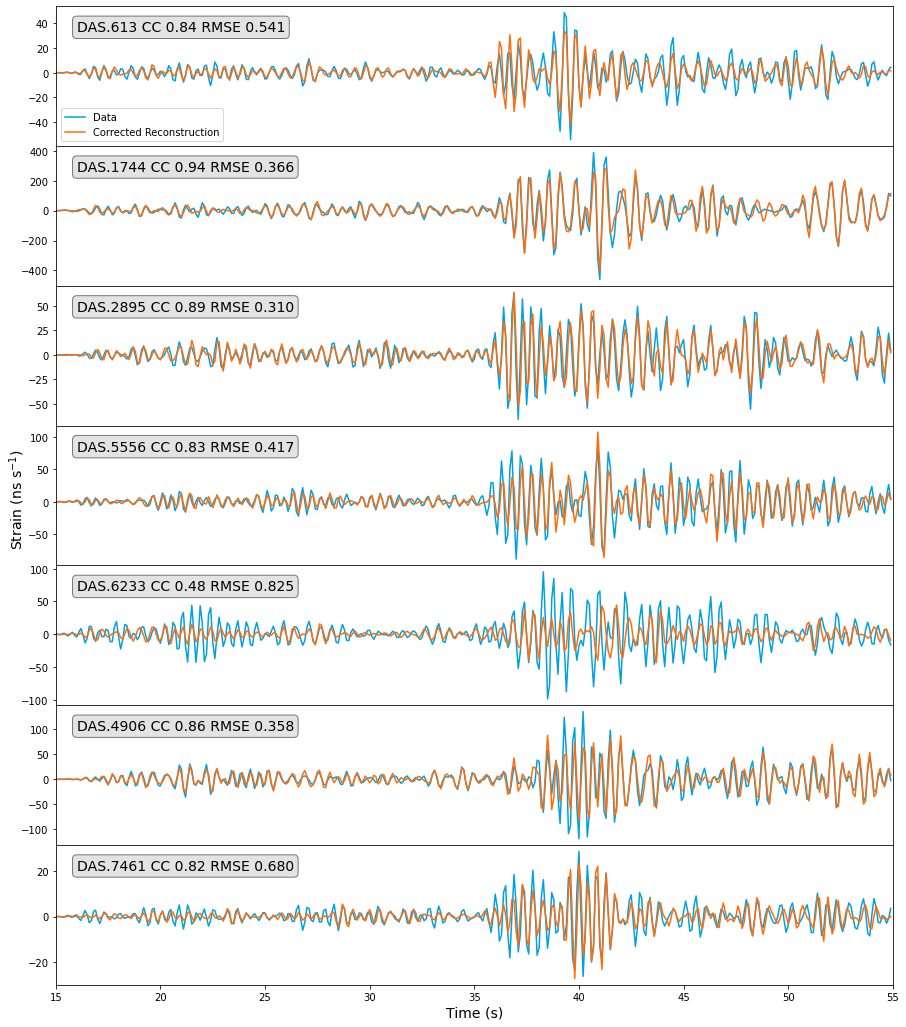

In [120]:
props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

fig, axes = plt.subplots(7,1,figsize=(15,18))

for i, (chi, chn) in enumerate(zip(chanidx, channames)):
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_data_obs[chi], label="Data", color=colorb)
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_pred_corr[chi], label="Corrected Reconstruction", color=coloro)
    axes[i].text(0.025, 0.9, fr"DAS.{int(chn)} CC {cc2[chi][0]:.2f} RMSE {rms2[chi]:.3f}", transform=axes[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    axes[i].set_xlim(15,55)
    if i != (len(axes)-1):
        axes[i].set_xticks([])
    else:
        axes[i].set_xlabel("Time (s)", fontsize=14)
        
    if i == 0:
        axes[i].legend(loc="lower left")

    
fig.subplots_adjust(hspace=0.0)
fig.text(0.08, 0.5, r'Strain (ns s$^{-1}$)', va='center', rotation='vertical', fontsize=14)
fig.savefig("node_to_das_comparison_corrected_stats.pdf")

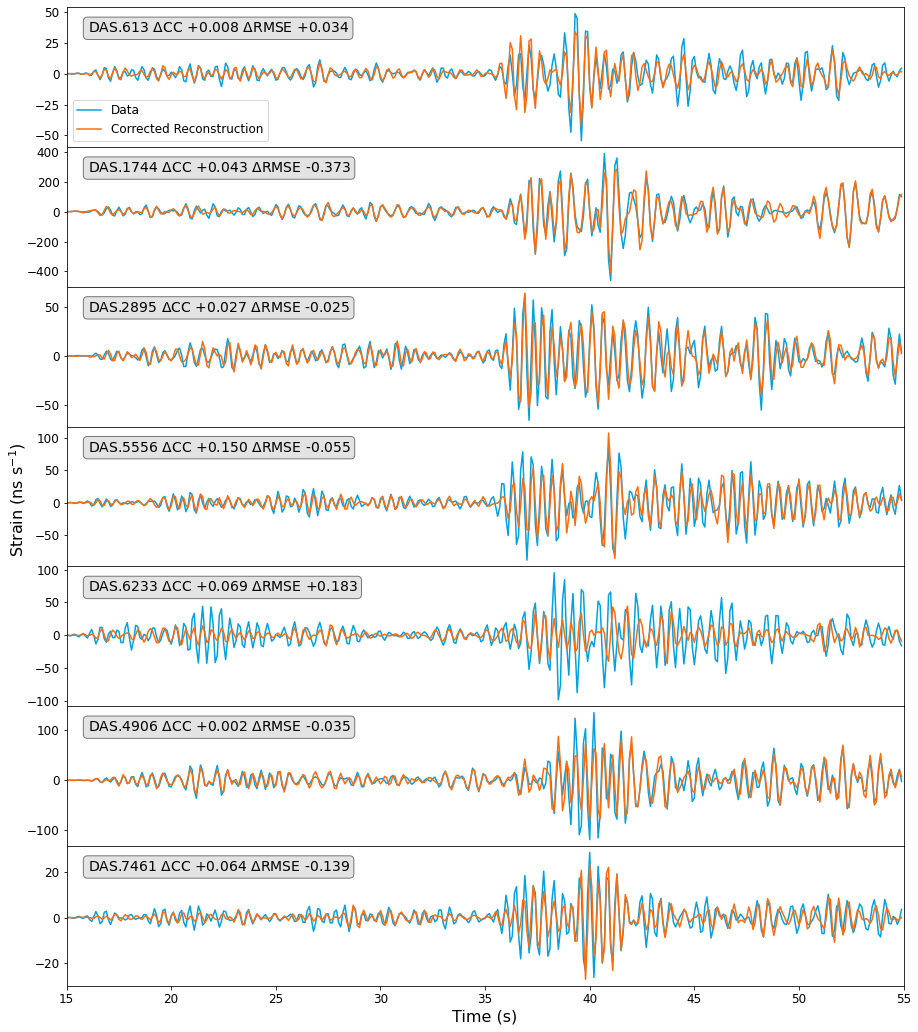

In [121]:
props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

fig, axes = plt.subplots(7,1,figsize=(15,18))

for i, (chi, chn) in enumerate(zip(chanidx, channames)):
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_data_obs[chi], label="Data", color=colorb)
    axes[i].plot(15+np.arange(400)*0.1, 1e3*das_pred_corr[chi], label="Corrected Reconstruction", color=coloro)
    axes[i].text(0.025, 0.9, fr"DAS.{int(chn)} $\Delta$CC {cc2[chi][0]-cc1[chi][0]:+.3f} $\Delta$RMSE {rms2[chi]-rms1[chi]:+.3f}", transform=axes[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    axes[i].set_xlim(15,55)
    if i != (len(axes)-1):
        axes[i].set_xticks([])
        axes[i].tick_params(axis='y', labelsize=12)
    else:
        axes[i].set_xlabel("Time (s)", fontsize=16)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

        
    if i == 0:
        axes[i].legend(loc="lower left", fontsize=12)

    
fig.subplots_adjust(hspace=0.0)
fig.text(0.07, 0.5, r'Strain (ns s$^{-1}$)', va='center', rotation='vertical', fontsize=16)
fig.savefig("node_to_das_comparison_corrected_delta_stats.pdf")

(15.0, 60.0)

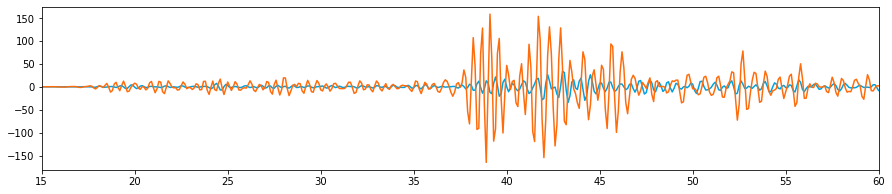

In [122]:
chi = 1214
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(600)*0.1+1.7, 1e3*das_data[chi], label="Data", color=colorb)
plt.plot(np.arange(602)*0.1, 1e3*das_predict_td[chi]*Gn_das/Gn_nodes, label="Reconstruction", color=coloro)
plt.xlim(15,60)

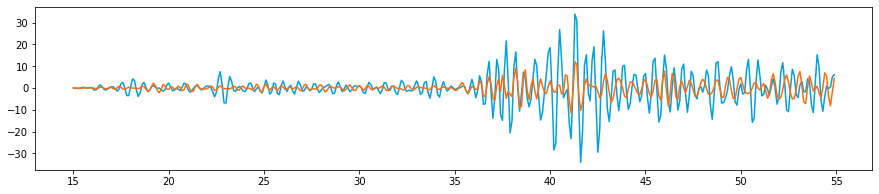

In [123]:
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(15+np.arange(400)*0.1, 1e3*das_data_obs[chi], label="Data", color=colorb)
plt.plot(15+np.arange(400)*0.1, 1e3*das_pred_corr[chi], label="Corrected Reconstruction", color=coloro)